# Images

Images are just arrays of data, where the data tells us the colors in the image. It will get a little more complicated than this, as we'll see below, but this is the general idea. Since colors are typically represented by three dimensions, image arrays are typically [M x N x 3], and sometimes [M x N x 4], where the final entry of the last dimension contains the alpha or transparency value.

In [4]:
import requests  # from webscraping
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
import cmocean
import cartopy

from PIL import Image  # this is the pillow package
from skimage import color
from scipy import ndimage
from io import BytesIO

## ***Note***
We'll use an image of [Grace Hopper](https://en.wikipedia.org/wiki/Grace_Hopper) for our sample image. Grace was one of the first computer programmers, invented the first computer compiler, and was a US Navy Rear Admiral. She's so important that `matplotlib` contains a picture of her!

# A. Reading in and viewing images

## Reading

### `matplotlib`

There is a basic read function in `matplotlib.pyplot`: `imread`:

In [5]:
hoppermpl = plt.imread(matplotlib.cbook.get_sample_data("grace_hopper.png"))

What does `hoppermpl` look like and contain?

In [6]:
print(hoppermpl.shape, type(hoppermpl))
hoppermpl

(600, 512, 3) <class 'numpy.ndarray'>


array([[[ 0.08235294,  0.09411765,  0.3019608 ],
        [ 0.10588235,  0.11764706,  0.33333334],
        [ 0.12941177,  0.13725491,  0.36078432],
        ..., 
        [ 0.29803923,  0.44705883,  0.74117649],
        [ 0.27843139,  0.42745098,  0.72156864],
        [ 0.29803923,  0.44705883,  0.74117649]],

       [[ 0.10196079,  0.11372549,  0.32156864],
        [ 0.09803922,  0.10980392,  0.32549021],
        [ 0.10196079,  0.10980392,  0.33333334],
        ..., 
        [ 0.23529412,  0.38431373,  0.67843139],
        [ 0.21960784,  0.36862746,  0.66274512],
        [ 0.24313726,  0.39215687,  0.68627453]],

       [[ 0.08235294,  0.09411765,  0.3019608 ],
        [ 0.07843138,  0.09019608,  0.30588236],
        [ 0.07843138,  0.08627451,  0.30980393],
        ..., 
        [ 0.30980393,  0.45882353,  0.74509805],
        [ 0.3137255 ,  0.4627451 ,  0.74901962],
        [ 0.34509805,  0.49411765,  0.78039217]],

       ..., 
       [[ 0.60000002,  0.05098039,  0.09411765],
        

... just a bunch of numbers in an array with shape [M x N x 3].

### Python Imaging Library

The Python Imaging Library (PIL) is a package for image manipulation that is in wide use. We'll use the Pillow branch of PIL, which is the name of the fork still being developed and maintained. `Image` is contained within `PIL`.

In [7]:
hopperpil = Image.open(matplotlib.cbook.get_sample_data("grace_hopper.png"))

What does `hopperpil` look like and contain?

<class 'PIL.PngImagePlugin.PngImageFile'>


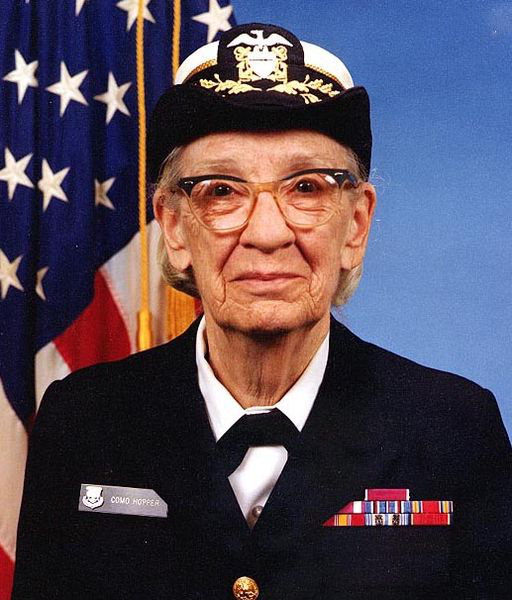

In [8]:
print(type(hopperpil))
hopperpil

The PIL PngImageFile object defaults to a convenient view of the picture itself.

## Viewing

We have a sneak peak at the photo of Grace Hopper from the PIL Image object, but we'll also want to be able to plot the image other ways in which we have more control. Generally for plotting, we'll want to have the data in the form of an array, though there are other options using the PIL package and a PIL object directly.

Let's try the way we've been plotting a lot of our data: `pcolormesh` or `contourf`:

ValueError: too many values to unpack (expected 2)

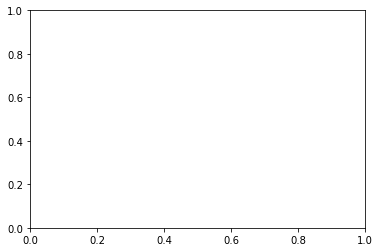

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(hoppermpl)

Why didn't that work?

When we've used `pcolor` or `contourf` in the past, we've always used a 2D array of data (or a single slice of a 3d array). However, this data is 3D due to having red, green, and blue values. Thus, there are too many dimensions to plot it this way.

Instead, we need to use special image-based functions to plot RGB data, for example, `imshow`:

In [ ]:
fig = plt.figure(figsize=(14, 14))
ax1 = fig.add_subplot(1, 2, 1)
ax1.imshow(hoppermpl)
ax1.set_title('data via matplotlib')

# Get an array of data from PIL object
hopperpilarr = np.asarray(hopperpil)

ax2 = fig.add_subplot(1, 2, 2)
ax2.imshow(hopperpilarr)
ax2.set_title('data via PIL')

Notice that the x-axis 0 value is, as usual, at the left side of the figure. However, the y-axis 0 value is at the top of the figure instead of the typical bottom. This makes the origin for the coordinate axes at the top left instead of the bottom left. This is the convention for image data.

# B. Converting between colorspaces

In [RGB](https://en.wikipedia.org/wiki/RGB_color_model), colorspace is represented as a cube of values from 0 to 1 (or 0 to 255 or 1 to 256, depending on the specific algorithm) for each of red, green, and blue, which, when combined, represent many colors. The Hopper images are currently in RGB. However, RGB is but one representation of color. We could, instead, represent color by its hue, saturation, and value ([HSV](https://en.wikipedia.org/wiki/HSL_and_HSV)), where hue is a circular property from red to yellow to blue and back to red, saturation is the vividness of the color, and value or brightness goes from black to white. And there are many others.

There are at least a handful of Python packages out there you can use to convert color triplets between colorspaces, including [`colorspacious`](https://colorspacious.readthedocs.org/en/latest/index.html) which has more options, but we'll use `scikit-image`.

In [ ]:
hopperhsv = color.convert_colorspace(hoppermpl, "RGB", "HSV")
hopperhsv

In [ ]:
plt.plot(hoppermpl[:,:,0], hopperhsv[:,:,0], '.k');

So the HSV representation is still an array of numbers of the same shape, but they are for sure different: if they were the same, plotting them against each other would give a 1-1 correspondence.

# C. Converting to grayscale

An image can be represented by shades of gray instead of in 3D colorspace; when you convert to grayscale from 3D colospace, you inherently discard information. There are many ways of doing this [transformation](http://www.tannerhelland.com/3643/grayscale-image-algorithm-vb6/) (this link is a great resource). 

How might we convert to grayscale? We have RGB information, which is more than we need. What if we just take one channel?

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.pcolormesh(hoppermpl[:,:,0])

What is wrong here? For one thing, she is upside down. Another is that she is still colored though didn't we just eliminate all but one color channel?

We can fix the flip in plotting by either flipping the axes by hand or by using a function that is meant to plot image data, like `matshow`.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(hoppermpl[:,:,0])

Grace is being colored by the default colormap, giving her a strange look. Let's choose the grayscale colormap to match our expectations in what we're doing here.

In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(hoppermpl[:,:,0], cmap='gray')

---
### *Exercise*

> How good is this representation of the photo in grayscale? Try the other two channels and compare, side-by-side. Which gives the best representation? Why?

---

---
### *Exercise*

> How else might we use the given RGB data to represent the image in grayscale? Play around with different approaches and be ready to discuss why one is better than another.

---

We can also just use a built-in function for conversion to grayscale, such as from `scikit-image`:

In [ ]:
hoppergray = color.rgb2gray(hoppermpl)
print(hoppergray.shape)

fig = plt.figure()
ax = fig.add_subplot(111)
ax.matshow(hoppergray, cmap='gray')

# D. Data in `png` files

Image file format `png` is worth a specific discussion due to its use in applications like satellite data. The [pixel format](https://en.wikipedia.org/wiki/Portable_Network_Graphics#Pixel_format) of the pixels in a `png` file can have different numbers of dimensions, representing different things. We'll focus on two cases here: the [M x N x 3] and [M x N] cases.

Returning to our web scraping example using satellite data, we find that different types of satellite data products have differently-sized arrays. Note that when you go to the [website](http://optics.marine.usf.edu/) and examine the information associated with various satellite products, you get hints about how many channels of data it should contain.

First we examine an RGB composite image. The (edited) note associated with this data on the website is as follows:

> RGB: Red-Green-Blue composite image showing clouds, ocean, and land. The resulting reflectance in the three MODIS bands (645 nm: R; 555 nm: G; 469 nm: B) is stretched to 0-255 to obtain the RGB image.

This turns out to be pretty straight-forward to plot if we just treat the data we've read in as an image:

In [ ]:
# RGB
image_loc = 'http://optics.marine.usf.edu/subscription/modis/GCOOS/2016/daily/091/A20160911855.1KM.GCOOS.PASS.L3D_RRC.RGB.png'
response = requests.get(image_loc)  # choose one of the files to show as an example
img = Image.open(BytesIO(response.content))
rgb = np.asarray(img)
print(rgb.shape)
plt.imshow(rgb)

Next we examine a sea surface temperature (SST) image. Here is the edited data note from the site:

> SST: Sea Surface Temperature (in Degree C) estimated using the SeaDAS processing software (default product) with a multi-channel non-linear regression algorithm (Brown and Minnett, 1999). The MODIS standard product MOD35 (Ackerman et al., 2010) is used to discriminate clouds from water, and a cloudmask (grey color) is overlaid on the image.

What is this telling us? The data in the image is not represented in three channels like in the previous example, but in a single channel or index. It [*looks*](http://optics.marine.usf.edu/subscription/modis/GCOOS/2016/daily/091/A20160911855.1KM.GCOOS.PASS.L3D.SST.png) like it is represented in 3D colorspace, but really what we are seeing is a single channel of data being mapped using a colormap, just like in any of our typical data plots using `pcolormesh`, etc. This means that we are working to access the data points themselves, which we will then want to plot with our own colormap for representation.

In [ ]:
# SST
image_loc = 'http://optics.marine.usf.edu/subscription/modis/GCOOS/2016/daily/091/A20160911855.1KM.GCOOS.PASS.L3D.SST.png'
response = requests.get(image_loc)  # choose one of the files to show as an example
img = Image.open(BytesIO(response.content))
index = np.asarray(img)
print(index.shape)
plt.matshow(index)

This has shape [M x N] instead of [M x N x 3], so we have used `matshow` instead of `imshow` to plot it. Still, the plot doesn't look very good, does it? The land has been colored as red, which is taking up part of our 0-255 data range. Let's examine this further with a histogram of the values in the data set.

In [ ]:
n, bins, patches = plt.hist(index.flatten(), range=[0,255], bins=256)  # use 256 bins, one for each color representation in the data.

We see a suspicious pattern in the data: there is a reasonable-looking spread of data in the lower part of the available bins, then nothing, then some big peaks with high, singular values (without a spread). This is telling us that the data itself is in the lower part of the representation range, and other parts of the image are represented with reserved larger values.

The histogram values give us a strong clue about this. We can also directly examine the colormap used in this data to figure out the range of data. The `PIL` function `getpalette` tells us this information as a list of RGB values:

In [ ]:
img.getpalette()

We need to change this information into a colormap. To do so, we need an [N x 3] array of the colormap values, where N is probably going to be 256 but doesn't have to be. Then we convert this into a colormap object.

In [ ]:
# the -1 in reshape lets that dimension be what it needs to be
palette = np.asarray(img.getpalette()).reshape(-1, 3)  # change list to array, then reshape into [Nx3]
palette.shape

In [ ]:
cmap = cmocean.tools.cmap(palette)  # Create a colormap object

In [ ]:
plt.matshow(index, cmap=cmap, vmin=0, vmax=255)  # use the colormap object
plt.colorbar()

So where exactly is the cut off for the range of data values? Here we examine the colormap values:

In [ ]:
plt.plot(palette)
# plt.gca().set_xlim(230, 250)

Looks like the highest data value is 235, so everything above that can be masked out.

### also: x and y coordinates

We want the appropriate x and y coordinates to go with our image. There is information about this on the [data page](http://optics.marine.usf.edu/cgi-bin/optics_data?roi=GCOOS&current=1):

    The Gulf of Mexico Coastal Ocean Observing System region is an area bounded within these coordinates: 31°N 18°N 79°W and 98°W.
    ...
    All images are mapped to a cylindrical equidistant projection. Images are at 1 kilometer resolution.

A cylindrical equidistant projection is just lon/lat.

In [ ]:
lon = np.linspace(-98, -79, index.shape[1])  # know the number of longitudes must match corresponding number in image array
lat = np.linspace(18, 31, index.shape[0])
lat = lat[::-1]  # flipping it makes plotting later work immediately

---
### *Exercise*

> Continue below to finish up the plot.

> Mask out the land (contained in `index`):

---

> Make a new colormap instance that includes only the data range and not the masking values (since `palette` also contains color information for the land):

> Plot the satellite data. What should the range of data be? Be sure to show the colorbar to check your work.

> How about a good colormap to finish off the plot?

---

Ok. So we have a plot with a reasonable range for the data and the image looks pretty good. What do these values represent, though? The `color index` probably doesn't actually have values from `datamin` to `datamax`. Rather, we have to determine the range of the data that was used in the originally plotted colormap and transform the values to span the correct range.

How do we do this? To start, we need to know the colorbar min and max that were used in the original image. It turns out that while this information is not on the png, it is on the google earth representation. [Here](http://optics.marine.usf.edu/cgi-bin/optics_data?roi=MRIVER&Date=4/5/2016&Pass=A1915) is a direct link to that data page so we can click around.

---
### *Exercise*

> Find the min/max values of the data. Then think about how to convert your index data into temperature data within this range.

> Once you've converted the data, make a proper plot of the satellite data!

---

## Image Analysis

Let's start with a simple image, but keep in mind that these techniques could be applied also to data arrays that aren't images.

In [ ]:
image_loc = 'https://upload.wikimedia.org/wikipedia/commons/c/c4/PM5544_with_non-PAL_signals.png'
response = requests.get(image_loc)
img = Image.open(BytesIO(response.content))  # using PIL

index = np.asarray(img)
plt.imshow(index)

### Filtering

In [ ]:
findex = ndimage.gaussian_filter(index, 2.0)    # filters in all 'three' dimensions, including channel...
plt.imshow(findex)                              # ...probably not what we want.

Filtering without paying attention to the dimensions of the array altered the colors of the image. But, if we instead filter in space for each channel individually:

In [ ]:
sigma = 2.0    # Standard deviation of the gaussian kernel. Bigger sigma == more smoothing.

findex = np.zeros_like(index)
for channel in range(3):
    findex[:, :, channel] = ndimage.gaussian_filter(index[:, :, channel], sigma=sigma)

plt.imshow(findex)

---
###  *Exercise*

> Modify the sigma parameter, and see what happens to the image.

---

### Gradients

Now, let's see if we can find gradients in this image. To make it easier, let's make a grayscale representation of the image by summing the RGB channels.

In [ ]:
gsindex = index.sum(axis=-1)

fig = plt.figure(figsize=(7.68, 5.76), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
plt.imshow(gsindex, cmap='gray')

We use a Sobel filter (Sobel Operator) to quickly search calculate gradients in the image array.

In [ ]:
# FINDING GRADIENTS

from scipy.ndimage import sobel, generic_gradient_magnitude
d_gsindex = ndimage.generic_gradient_magnitude(gsindex, sobel)

# Note screen resolution is about 100dpi, so lets make sure the image is big enough to see all the points.
fig = plt.figure(figsize=(7.68, 5.76))
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.matshow(d_gsindex, cmap='gray')

### Interpolation

Quick review of interpolation. When you have an image, or a data array on a uniform grid, `map_coordinates` is the best way to interpolate.

In [ ]:
# INTERPOLATION/MAPPING

x = 768*np.random.rand(50000)
y = 578*np.random.rand(50000)
xy = np.vstack((y, x))

z = ndimage.map_coordinates(gsindex, xy)
plt.scatter(x, y, 10, z, edgecolor='none')

### Rotation

In [ ]:
# ROTATING

rgsindex = ndimage.rotate(gsindex, 15, mode='wrap')
fig = plt.figure(figsize=(7.68, 5.76), dpi=100)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
plt.imshow(rgsindex, cmap='gray')

# Note, the image size increased to accomodate the rotation.
print(rgsindex.shape, gsindex.shape)

---
###  *Exercise*

> Try some other rotations. Does the increase in image size make sense based on trigenometry? What happens with a 90deg
rotation?

> Look at the documentation, and try different modes. What's the difference between 'constant' and 'wrap'?

> Try rotating back and forth 15 degrees at least 10 times, using various modes (and be be sure to set 'reshape=False' to prevent the image from growing over the iterations).

---

### An example of edge detection

Let's use some of these tools to generate a sample image – a rotated square with softened edges, and some noise added.

In [ ]:
im = np.zeros((128, 128))
im[32:-32, 32:-32] = 1

im = ndimage.rotate(im, 15, mode='constant')
im = ndimage.gaussian_filter(im, 4)
im += 0.2 * np.random.random(im.shape)

plt.imshow(im, cmap='viridis')

Now, try to detect the edges of this feature using the `scikit image` canny edge detection algorithm:

In [ ]:
from skimage import feature

edges = feature.canny(im, sigma=1)    # sigma=1 is the default
plt.imshow(edges, cmap='viridis')

---
###  *Exercise*

> Try different values of sigma to see if you can isolate the square as the only feature detected.

---

Now let's find the convex hull of the edges that we detected (hopefully only the single square now):

In [ ]:
from skimage.morphology import convex_hull_image

chull = convex_hull_image(edges)
plt.imshow(chull, cmap='viridis')

This would work even for an 'open' object, 

In [ ]:
diag_mask = np.triu(np.ones(im.shape))
edges = edges.astype('float') * diag_mask

chull = convex_hull_image(edges)

fig, axs = plt.subplots(1, 2)

axs[0].imshow(edges, cmap='viridis')
axs[1].imshow(chull, cmap='viridis')

### Other feature detection

Here we use an image from the Hubble telescope showing stars and galaxies as bright dots. We want to detect the galaxies automatically.

We look at three algorithms for doing this.

In [ ]:
from skimage import data
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.color import rgb2gray

image = data.hubble_deep_field()[0:500, 0:500]
image_gray = rgb2gray(image)

plt.imshow(image_gray, cmap='gray')

Here is the Laplacian of Gaussian method as an example. How many galaxies are found depends on the `threshold` parameter especially.

In [ ]:
blobs_log = blob_log(image_gray, max_sigma=30, num_sigma=10, threshold=.4)

# the data are x, y, sigma for all the blobs. Lets make a quick plot.

y = blobs_log[:, 0]
x = blobs_log[:, 1]
sigma = blobs_log[:, 2]
# Calculate the radius of the blob from sigma, which is given in the docs as:
r = sigma*np.sqrt(2)

# represent marker size with r^2 to approximate area, and use log10(r) to give a spread in colors
plt.scatter(x, -y, r**2, np.log10(r), cmap='viridis', edgecolor='none')
plt.colorbar()
plt.axis('tight')
plt.gca().set_aspect(1.0)

Here we show the three algorithms. The Laplacian of Gaussian (LoG) is the most accurate and slowest approach. The Difference of Gaussian (DoG) is a faster approximation of LoG approach. The Determinant of Hessian is the fastest approach but is not accurate for small blobs. More details are available [online](http://scikit-image.org/docs/dev/auto_examples/plot_blob.html).

In [ ]:
blobs_dog = blob_dog(image_gray, max_sigma=30, threshold=.1)
# For this method, the radius is again found by multiplying by sqrt(2)
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)

# for this method, the third output parameter is already approximately the blob radius
blobs_doh = blob_doh(image_gray, max_sigma=30, threshold=.01)

blobs_list = [blobs_log, blobs_dog, blobs_doh]
colors = ['yellow', 'lime', 'red']
titles = ['Laplacian of Gaussian', 'Difference of Gaussian',
          'Determinant of Hessian']

fig, axes = plt.subplots(1, 3, figsize=(14, 4), sharex=True, sharey=True)
plt.tight_layout()

# loop over the parameters in `zip` simultaneously
for blobs, color, title, ax in zip(blobs_list, colors, titles, axes):
    ax.set_title(title)
    # Show blogs
    ax.imshow(image, interpolation='nearest')
    ax.set_axis_off()
    # plot detected blobs over blobs to compare
    for blob in blobs:
        y, x, r = blob
        c = plt.Circle((x, y), r, color=color, linewidth=2, fill=False)
        ax.add_patch(c)

plt.show()